In [28]:
import seaborn as sns
import os.path as path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, precision_score
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from tqdm import tqdm
import eli5

In [3]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [4]:
tqdm.pandas()
data_dir = "./ember2018"

In [5]:
fn_X_sample = path.join(data_dir, 'X_sample-100K.dat')
fn_y_sample = path.join(data_dir, 'y_sample-100K.dat')

In [6]:
X = np.memmap(fn_X_sample, dtype='float32', mode='r', shape=(100000, 2381))
y = np.memmap(fn_y_sample, dtype='float32', mode='r', shape=(100000,))

In [7]:
X.shape, y.shape

((100000, 2381), (100000,))

In [8]:
y.mean()

0.5

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 2381), (20000, 2381), (80000,), (20000,))

In [11]:
y_train.mean(), y_test.mean()

(0.5, 0.5)

### Standarize the X_train and X_test

In [12]:
ss = StandardScaler()

In [13]:
%%time
ss.fit(X_train)

CPU times: user 1.96 s, sys: 685 ms, total: 2.64 s
Wall time: 2.64 s


StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
%%time
X_train = ss.transform(X_train)

CPU times: user 1.19 s, sys: 185 ms, total: 1.38 s
Wall time: 1.38 s


In [15]:
%%time
X_test = ss.transform(X_test)

CPU times: user 310 ms, sys: 43.1 ms, total: 353 ms
Wall time: 351 ms


In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 2381), (20000, 2381), (80000,), (20000,))

In [17]:
def model_evaluation(pipeline_in):
    #scores = cross_val_score(pipeline_in, X, y_class)
    #print(f'Mean cross-val score: {scores.mean()}')
    #print(f'Standard deviation cross-val:{scores.std()}')
    
    pipeline_in.fit(X_train,y_train) # training the model
    pipeline_in.score(X_test,y_test) 
    y_hat_this = pipeline_in.predict(X_test)
    y_hat_pr_this = pipeline_in.predict_proba(X_test)
    #classification pr calibration + sklearn
    #pipeline_in.predict_proba(X_test)
    print(f'Accuration score with y_test & y_pred: {accuracy_score(y_test,y_hat_this)}')
    print('----------------------------------------')
    print('Classification Report')
    print('----------------------------------------')
    print(classification_report(y_test,y_hat_this))
    
    print('----------------------------------------')
    print('Confusion Matrix')
    print('----------------------------------------')
    conmat = np.array(confusion_matrix(y_test,y_hat_this,labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['is_high_salary', 'is_low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
    print(confusion)
    
    fpr, tpr, th = roc_curve(y_test, y_hat_pr_this[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=[5,5])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic for DS salary', fontsize=12)
    plt.legend(loc="lower right")
    plt.show()
    
    #display(eli5.explain_weights(pipeline_in))

# Experiment 6: Ensemble - XGBoost 

In [18]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

In [19]:
%%time
# Creating the pipeline
pl_e8 = make_pipeline(XGBClassifier())

lg_params8 = {'xgbclassifier__objective': ["binary:logistic"],
              'xgbclassifier__learning_rate': [0.1],
              'xgbclassifier__n_estimators': [40],
             'xgbclassifier__max_depth': [5]}
lg_grid8 = GridSearchCV(pl_e8, param_grid=lg_params8, cv=5, scoring="accuracy", n_jobs=-1)
lg_grid8.fit(X_train, y_train)

CPU times: user 5min 49s, sys: 1.47 s, total: 5min 51s
Wall time: 15min 39s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'xgbclassifier__objective': ['binary:logistic'], 'xgbclassifier__learning_rate': [0.1], 'xgbclassifier__n_estimators': [40], 'xgbclassifier__max_depth': [5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [21]:
%%time
XGBoost_best = lg_grid8.best_score_
print(lg_grid8.best_params_)
print(lg_grid8.best_score_)
pl_e8.set_params(**lg_grid8.best_params_)

{'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 40, 'xgbclassifier__objective': 'binary:logistic'}
0.9380625
CPU times: user 573 µs, sys: 5 µs, total: 578 µs
Wall time: 438 µs


Pipeline(memory=None,
     steps=[('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=40, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))])

Accuration score with y_test & y_pred: 0.9394
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     10000
         1.0       0.94      0.93      0.94     10000

   micro avg       0.94      0.94      0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                   9343                   657
is_low_salary                     555                  9445


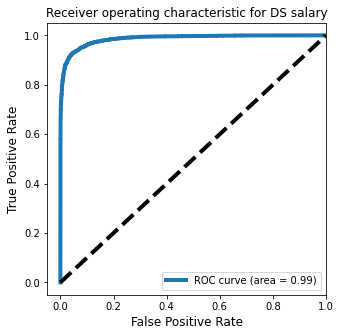

CPU times: user 5min 55s, sys: 1.4 s, total: 5min 56s
Wall time: 5min 56s


In [22]:
%%time
model_evaluation(pl_e8)

### Experiment 2 -XGBoost

In [17]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

In [24]:
%%time
# Creating the pipeline
pl_e9 = make_pipeline(XGBClassifier())

lg_params9 = {'xgbclassifier__objective': ["binary:logistic"],
              'xgbclassifier__learning_rate': [0.1],
              'xgbclassifier__n_estimators': [40],
             'xgbclassifier__max_depth': [4,5]}
lg_grid9 = GridSearchCV(pl_e9, param_grid=lg_params9, cv=5, scoring="accuracy", n_jobs=-1)
lg_grid9.fit(X_train, y_train)

CPU times: user 5min 59s, sys: 1.51 s, total: 6min 1s
Wall time: 20min 9s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'xgbclassifier__objective': ['binary:logistic'], 'xgbclassifier__learning_rate': [0.1], 'xgbclassifier__n_estimators': [40], 'xgbclassifier__max_depth': [4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [25]:
%%time
XGBoost1_best = lg_grid9.best_score_
print(lg_grid9.best_params_)
print(lg_grid9.best_score_)
pl_e9.set_params(**lg_grid9.best_params_)

{'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 40, 'xgbclassifier__objective': 'binary:logistic'}
0.9380625
CPU times: user 999 µs, sys: 0 ns, total: 999 µs
Wall time: 652 µs


Pipeline(memory=None,
     steps=[('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=40, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))])

Accuration score with y_test & y_pred: 0.9394
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     10000
         1.0       0.94      0.93      0.94     10000

   micro avg       0.94      0.94      0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                   9343                   657
is_low_salary                     555                  9445


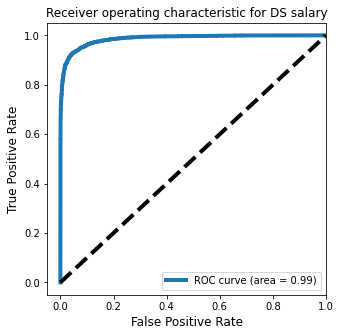

CPU times: user 5min 55s, sys: 1.41 s, total: 5min 56s
Wall time: 5min 56s


In [26]:
%%time
model_evaluation(pl_e9)